In [26]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil
from scipy.optimize import curve_fit

In [27]:
f = h5pyd.File("/nrel/wtk-us.h5")
# list the datasets in the file
for k in f:
    dset = f[k]
    print(f"{dset.name} {dset.shape}")

/DIF (61368, 1602, 2976)
/DNI (61368, 1602, 2976)
/GHI (61368, 1602, 2976)
/coordinates (1602, 2976)
/datetime (61368,)
/inversemoninobukhovlength_2m (61368, 1602, 2976)
/precipitationrate_0m (61368, 1602, 2976)
/pressure_0m (61368, 1602, 2976)
/pressure_100m (61368, 1602, 2976)
/pressure_200m (61368, 1602, 2976)
/relativehumidity_2m (61368, 1602, 2976)
/status (61368,)
/temperature_100m (61368, 1602, 2976)
/temperature_10m (61368, 1602, 2976)
/temperature_120m (61368, 1602, 2976)
/temperature_140m (61368, 1602, 2976)
/temperature_160m (61368, 1602, 2976)
/temperature_200m (61368, 1602, 2976)
/temperature_2m (61368, 1602, 2976)
/temperature_40m (61368, 1602, 2976)
/temperature_60m (61368, 1602, 2976)
/temperature_80m (61368, 1602, 2976)
/winddirection_100m (61368, 1602, 2976)
/winddirection_10m (61368, 1602, 2976)
/winddirection_120m (61368, 1602, 2976)
/winddirection_140m (61368, 1602, 2976)
/winddirection_160m (61368, 1602, 2976)
/winddirection_200m (61368, 1602, 2976)
/winddirection

In [28]:
# Assuming the dataset is already connected using h5pyd
# Replace 'your_dataset' with the actual dataset name and adjust the slicing/indexing as needed
dataset = f['windspeed_10m']
dataset.shape


(61368, 1602, 2976)

In [29]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

twentyten = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twentyten

Index([26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313,
       ...
       35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063],
      dtype='int64', length=8760)

In [50]:
# Calculate the temporal resolution/timestep
time_step = dt['datetime'].diff().iloc[1]
print(f"The temporal resolution/timestep is: {time_step}")

# Calculate the spatial resolution
coordinates = f['coordinates']
lat_diff = np.abs(coordinates[1, 0]['lat'] - coordinates[0, 0]['lat'])
lon_diff = np.abs(coordinates[0, 1]['lon'] - coordinates[0, 0]['lon'])
spatial_resolution = (lat_diff, lon_diff)
print(f"The spatial resolution is: {spatial_resolution}")

The temporal resolution/timestep is: 0 days 01:00:00
The spatial resolution is: (np.float64(0.01596800000000087), np.float64(0.016968000000005645))


In [31]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

In [32]:
JordanLake = (38.47240422490422, -96.0)
JordanLake_idx = indicesForCoord(f, JordanLake[0], JordanLake[1])

print("y,x indices for Jordan Lake: \t\t {}".format(JordanLake_idx))
print("Coordinates of Jordan Lake: \t {}".format(JordanLake))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][JordanLake_idx[0]][JordanLake_idx[1]]))

y,x indices for Jordan Lake: 		 (801, 1488)
Coordinates of Jordan Lake: 	 (38.47240422490422, -96.0)
Coordinates of nearest point: 	 (38.481663, -95.98819)


In [33]:
# Get the entire 2010 timeseries data for Jordan Lake
%time tseries = dataset[min(twentyten):max(twentyten)+1, JordanLake_idx[0], JordanLake_idx[1]]

CPU times: total: 0 ns
Wall time: 5.13 s


Text(0.5, 1.0, 'Jordan Lake Windspeed in 2010')

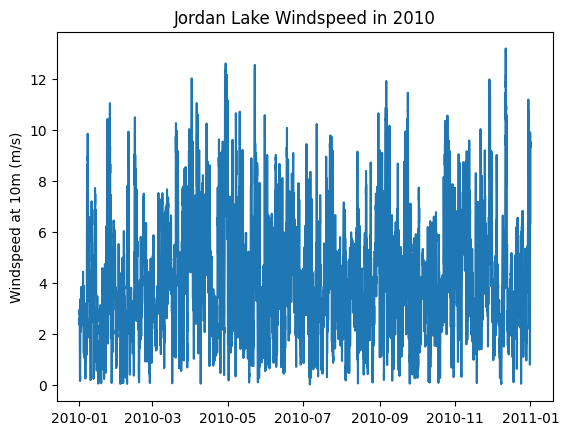

In [34]:
plt.plot(dt.iloc[twentyten,].datetime, tseries)
plt.ylabel("Windspeed at 10m (m/s)")
plt.title("Jordan Lake Windspeed in 2010")

In [45]:
# Define the Matérn-1/2 kernel function
def matern_12_kernel(t, length_scale, variance):
    return variance * np.exp(-np.abs(t) / length_scale)

# Compute the time differences (lags) and corresponding variances
lags = np.arange(1, 24*4)
variances = [np.var(tseries[:-lag] - tseries[lag:]) for lag in lags]

# Fit the Matérn-1/2 kernel to the variogram
popt, _ = curve_fit(matern_12_kernel, lags, variances, p0=[10, 1])

# Extract the temporal length scale
temporal_length_scale = popt[0]
print(f"Estimated temporal length scale: {temporal_length_scale}")

Estimated temporal length scale: 11528988035.070467


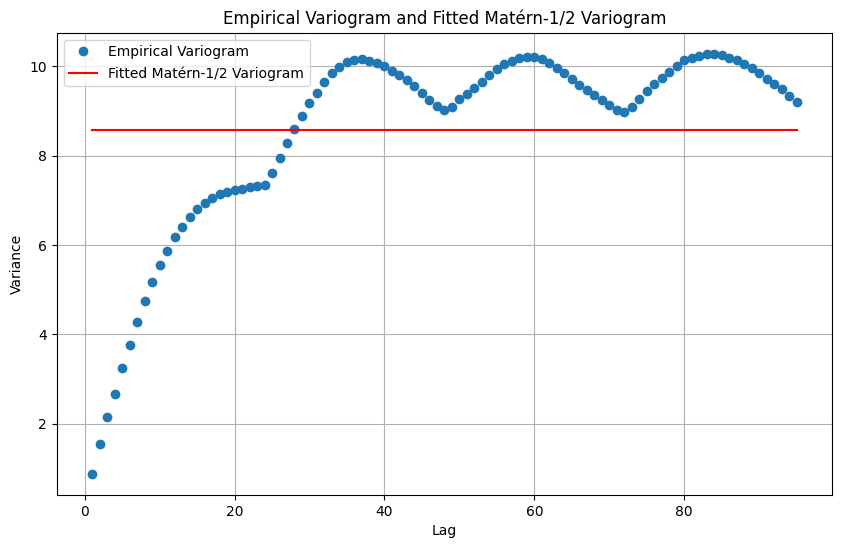

In [46]:
# Plot the empirical variogram
plt.figure(figsize=(10, 6))
plt.plot(lags, variances, label="Empirical Variogram", marker='o', linestyle='')

# Plot the fitted theoretical Matérn-1/2 variogram
fitted_variogram = matern_12_kernel(lags, *popt)
plt.plot(lags, fitted_variogram, label="Fitted Matérn-1/2 Variogram", color='red')

# Add labels, legend, and title
plt.xlabel("Lag")
plt.ylabel("Variance")
plt.title("Empirical Variogram and Fitted Matérn-1/2 Variogram")
plt.legend()
plt.grid()
plt.show()

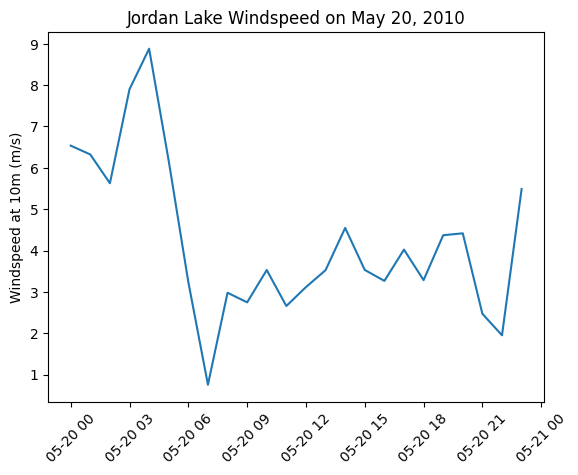

In [47]:
# Select a one-day sample (e.g., January 1, 2010)
one_day_indices = dt.loc[(dt['datetime'] >= '2010-05-20') & (dt['datetime'] < '2010-05-21')].index
one_day_tseries = dataset[min(one_day_indices):max(one_day_indices)+1, JordanLake_idx[0], JordanLake_idx[1]]

# Plot the one-day sample
plt.plot(dt.iloc[one_day_indices].datetime, one_day_tseries)
plt.ylabel("Windspeed at 10m (m/s)")
plt.title("Jordan Lake Windspeed on May 20, 2010")
plt.xticks(rotation=45)
plt.show()